# Topic modeling: application of Latent Dirichlet Allocation

<span style="color:green;font-weight:700;font-size:20px">
    Application for topics of sport news in The Guardian
</span> 


In this project, we look at sport news articles from *The Guardian* from Q1 and Q2 2022, and attempt to extract the main topics using LDA.

For this we implement a Bayesian approach towards topic modeling, which is LDA. The goals are both to test the reliability of the algorithm, in face of mixed reviews in literature, and draw potential insights.

## Requesting data from the API:

We first obtain data from the Guardian API; we attempt to bypass the limit of $\texttt{page-size}<200$ by looping over dates

Documentation: https://open-platform.theguardian.com/documentation/

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import time

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import os
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore, LdaModel, CoherenceModel
import gensim.corpora as corpora
import pyLDAvis.gensim_models

from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import random # insert path here

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ncozz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ncozz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\ncozz\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
apikey = 'your-api-key' # register for an API and obtain key

In [3]:
query = "sports"
query_url = f"https://content.guardianapis.com/sections?api-key={apikey}"
#query_url = f"https://content.guardianapis.com/sections?"

In [4]:
r = requests.get(query_url)

In [8]:
# function to pull data from The Guardian depending on section:
def query_the_guardian_json(section, query="", from_date="2022-01-01", to_date=datetime.today().strftime('%Y-%m-%d'),
                            type="article", apikey=apikey):
    query_fields = "body"
    section = "sport"  # https://open-platform.theguardian.com/documentation/section
    tag = ""  # https://open-platform.theguardian.com/documentation/tag

    rjson = {}
    dict_i = 0
    current_page = 1
    total_pages = 1
    if isinstance(from_date, str):
        date_loop = datetime.strptime(from_date, '%Y-%m-%d').date()
    if isinstance(to_date, str):
        date_end = datetime.strptime(to_date, '%Y-%m-%d').date()
    
    while date_loop <= date_end:#total_pages:
        print("Current date of query: "+ str(date_loop), end="\r")
        date_string = date_loop.strftime("%Y-%m-%d")
        query_url = f"https://content.guardianapis.com/search?" \
                f"api-key={apikey}" \
                f"&query-fields={query_fields}" \
                f"&total=999999999" \
                f"&type={type}" \
                f"&currentPage={current_page}" \
                f"&section={section}" \
                f"&from-date={date_string}" \
                f"&to-date={date_string}" \
                f"&page-size=200" \
                f"&show-fields=headline,byline,starRating,shortUrl,body"
            #    f"&pageSize=200" \
            #    f"&pages={total_pages}" \
        r = requests.get(query_url)
        r.raise_for_status()
        
        for i in range(len(r.json()['response']['results'])):
            rjson[dict_i] = r.json()['response']['results'][i]["fields"]
            dict_i+=1

        date_loop = date_loop + timedelta(days=1)
        #current_page += 1
        total_pages = r.json()['response']['pages']
    
    return rjson#.drop_duplicates()

In [10]:
guardian_json_sports = query_the_guardian_json(section="sport", query="", from_date="2022-01-01", to_date="2022-06-30")
#guardian_df_sports = guardian_df_sports.append(query_the_guardian_json(section="sport", query="", from_date="2022-02-01"), ignore_index=True)

In [4]:
len(guardian_json_sports)

2378

In [12]:
with open("data/theguardian.json", "w+") as f:
    json.dump(guardian_json_sports, f)

---------------------
We create an array with appended article bodies; here we remove the generic strings that suggest to "*download the Guardian app* [...]"

In [2]:
with open("data/theguardian.json", "r") as f:
    guardian_json_sports = json.load(f)

In [3]:
guardian_np = guardian_json_sports[str(0)]["body"].replace("Download the Guardian app from the iOS App Store on iPhones or the Google Play store on Android phones by searching for \'The Guardian\'.</li>\n     <li>If you already have the Guardian app, make sure you’re on the most recent version.", ""
                                                     ).replace("Turn on sport notifications.", "").replace(
    "In the Guardian app, tap the yellow button at the bottom right, then go to Settings (the gear icon), then Notifications.", "")
for i in range(1, len(guardian_json_sports)):
    guardian_np = np.append(guardian_np, guardian_json_sports[str(i)]["body"].replace("Download the Guardian app from the iOS App Store on iPhones or the Google Play store on Android phones by searching for \'The Guardian\'.</li>\n     <li>If you already have the Guardian app, make sure you’re on the most recent version.", ""
                                                                                ).replace("Turn on sport notifications.", "").replace(
        "In the Guardian app, tap the yellow button at the bottom right, then go to Settings (the gear icon), then Notifications.", ""))

## Exploratory analysis: word clouds

In [42]:
def clean_text(x):
    return BeautifulSoup(x.replace("\n", ""), "lxml").text

cloud_v = np.vectorize(clean_text)
cloud_np = cloud_v(guardian_np)

In [43]:
cloud_np[0]

'Michael Smith knocked out the defending champion and No 1 seed, Gerwyn Price, in a thriller to reach the semi-finals of the PDC world championship at Alexandra Palace. Smith, the runner-up to Michael van Gerwen in 2019, has the chance of another final appearance and will face James Wade in the semi-finals after his 5-4 victory over Price. The Welshman threw a nine-darter early on but he missed two match darts at the end of the eighth set, lost the next leg with the throw, and could not recover. Peter Wright came through another close-fought quarter-final, defeating Callan Rydz by the same score. Wright will face Gary Anderson next – in a clash of two 51-year-old Scots – after fighting back from 3-1 down.                Wade reached his first PDC world championship semi-final in nine years with a 5-0 win over Mervyn King, while the two-times world champion Anderson was forced to battle before coming past Luke Humphries with a 5-2 victory. Wade, the No 4 seed, has not made the last four

In [44]:
long_string = ','.join(list(cloud_np))

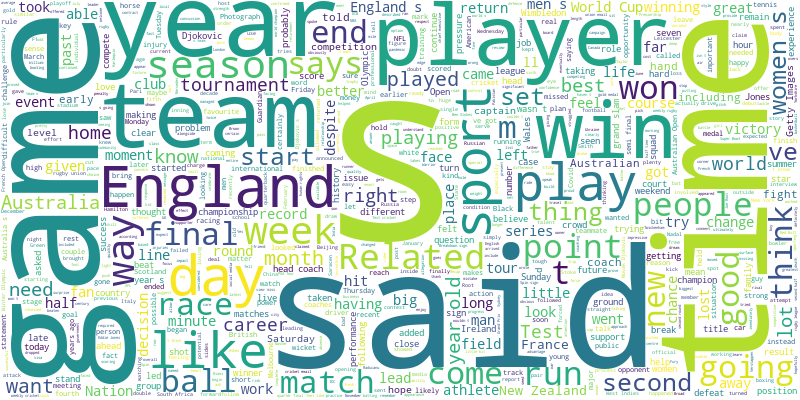

In [51]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',
                     stopwords=STOPWORDS, height=400 ,width=800)

wordcloud.generate(long_string)
wordcloud.to_image()

## Topic modeling: preprocessing data

First we choose to:
* Clean the texts' original HTML5 format by using $\texttt{BeautifulSoup}$
* **Remove stopwords** such as "and", "the", etcetera
* Remove other words observed in the word cloud
* **Lemmatize** words - that is, change all words into first person and present
* **Stemming** - that is reduce words to root form

Observations:
* N-grams are not considered due to computational power limitations; however, they could bring higher value in the analysis - example: names of players and teams
* Since LDA relies on count data for the respective multinomial distribution, we should **not** use TF-IDF

In [384]:
lemmatizer = WordNetLemmatizer()

stop_words = stopwords.words('english')
stop_words.extend(['s', 'said','say', 'time','would','one','two','three','four','like',
                  'day', 'also',  'u', 'get',
                   'year','month','week','could', 'since', 'head',
                  'really','old','way','want','much',
                  'come']) # from the word cloud

In [385]:
print(guardian_np[5])

<p>Jos Buttler says a chastening Ashes campaign – for himself and England – has not diminished his desire to remain a three-format player in international cricket. The 31-year-old wicketkeeper-batter has long since established himself as one of the leading limited-overs players in the world but so far his tour of Australia has continued a 56-cap Test career that, while not without highlights, is yet to live up to the same billing.</p> <p>Though a determined 207-ball rearguard on the final day of the second Test in Adelaide was commendable after coming in on a pair, dropped catches in that match and a rash dismissal during England’s first-innings collapse at the MCG have contributed to the 3-0 scoreline that leaves the tourists playing for pride in Sydney and Hobart.</p> <p>Asked if he still wanted to pursue Test cricket given his young family, his obvious market value in the less labour-intensive shorter formats and the recent decision by South Africa’s Quinton de Kock to <a href="http

-----------------------
We also observe that some articles refer to others through **"Related"**; let us take that into account

In [386]:
def clean_related(x): # allows for replacing "related sections"
    try:
        index_related = x.index('<span>Related:')
        index_end = x[index_related:].index('<p>')+index_related+3
        return x.replace(x[index_related:index_end],'')
    except:
        return x

def clean_text(x): # clears the HTML format
    return BeautifulSoup(x.replace("\n", ""), "lxml").text

def sent_to_words(sentences): # sentence to words
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def lemmatize_words(texts):
    return [[lemmatizer.lemmatize(word) for word in simple_preprocess(str(doc))] for doc in texts]

def ngramize(texts): # not implemented
    return texts.extend(list(ngrams(doc, 2,pad_left=True, pad_right=True)))

In [387]:
guardian_np_no_related = [clean_related(text) for text in guardian_np]

In [388]:
clean_v = np.vectorize(clean_text)
clean_np = clean_v(guardian_np_no_related)

In [389]:
data_words = list(sent_to_words(clean_np))
data_words = remove_stopwords(data_words)
data_words = lemmatize_words(data_words)
data_words = remove_stopwords(data_words)

## Latent Dirichlet Allocation

Latent Dirchlet Allocation is a statistical approach towards topic modeling, where:
* each topic is a combination of words drawn from a multinomial $\varphi \sim Dir(\alpha)$
* each document is a combination of topics drawn from a multinomial $\theta \sim Dir(\beta)$

Why is the Dirichlet distribution used? 
* This function is a multivariate generalization of the beta distribution (defined on the interval $(0,1)$), which allows modelling a set of probabilities of observing a vector - of words/topics
* The LDA algorithm uses Bayesian methods towards assigning probabilities; the Dirichlet distribution is a conjugate prior for the multinomial distribution, that is, the posterior distribution is also Dirichlet - which helps with data computation and with interpretation on any changes after updating with new data

Regarding the last point, let us remember that: $\text{posterior} \propto \text{prior} \times \text{likelihood}$

The LDA algorithm implements Expectation Maximization, which seeks to maximize the target likelihood function (of the resulting probability distribution)

For further understanding, it is recommended to study Bayesian methods


Script source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### Creating a dictionary and corpus

In [390]:
print(data_words[0])

['michael', 'smith', 'knocked', 'defending', 'champion', 'seed', 'gerwyn', 'price', 'thriller', 'reach', 'semi', 'final', 'pdc', 'world', 'championship', 'alexandra', 'palace', 'smith', 'runner', 'michael', 'van', 'gerwen', 'chance', 'another', 'final', 'appearance', 'face', 'james', 'wade', 'semi', 'final', 'victory', 'price', 'welshman', 'threw', 'nine', 'darter', 'early', 'missed', 'match', 'dart', 'end', 'eighth', 'set', 'lost', 'next', 'leg', 'throw', 'recover', 'peter', 'wright', 'came', 'another', 'close', 'fought', 'quarter', 'final', 'defeating', 'callan', 'rydz', 'score', 'wright', 'face', 'gary', 'anderson', 'next', 'clash', 'scot', 'fighting', 'back', 'wade', 'reached', 'first', 'pdc', 'world', 'championship', 'semi', 'final', 'nine', 'win', 'mervyn', 'king', 'world', 'champion', 'anderson', 'forced', 'battle', 'coming', 'past', 'luke', 'humphries', 'victory', 'wade', 'seed', 'made', 'last', 'king', 'rolled', 'back', 'clock', 'tournament', 'reaching', 'quarter', 'final', 'f

In [391]:
# Create Corpus
texts = data_words

# Create Dictionary
id2word = corpora.Dictionary(texts)
# Term Document Frequency
corpus = [id2word.doc2bow(text, allow_update=True) for text in texts]
corpus = corpus[0:len(corpus)]

print(corpus[:1][0][:30])

[(0, 1), (1, 3), (2, 2), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 8), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1)]


In [392]:
print(id2word)

Dictionary<39172 unique tokens: ['alexandra', 'anderson', 'another', 'appearance', 'back']...>


### Optimal number of topics

We find the optimal number of topics by maximizing the coherence value, which is a measure of similarity between highest scoring words in a topic

Reference: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

Code: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [393]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Current num_topics of query: "+ str(num_topics), end="\r")
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=314, passes=1,
                        iterations=50, chunksize=200)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [394]:
texts_sample = random.sample(texts,500)

id2word_sample = corpora.Dictionary(texts)

corpus_sample = [id2word.doc2bow(text, allow_update=True) for text in texts_sample]
corpus_sample = corpus_sample[0:len(corpus)]


In [395]:
start=5
limit=50
step=5

model_list, coherence_values = compute_coherence_values(dictionary=id2word_sample, corpus=corpus_sample,
                                                        texts=texts_sample, start=start, limit=limit, step=step)

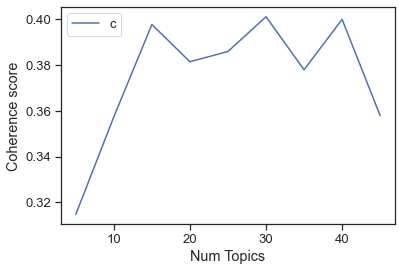

In [396]:
# Show graph
limit=limit; start=start; step=step;
#limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [401]:
n_topics_optimal = x[coherence_values.index(max(coherence_values))]
n_topics_optimal = 15

### Training the model

We choose to train the model with 15 topics, for sparsity purposes

**Note:** we can also tune the hyperparameters via CV - this is skipped here, but well recommended as well

In [402]:
import time
start = time.time()

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics_optimal,
                                            iterations = 100, random_state=314, passes=2)

end = time.time()
print("Time of execution for LdaModel: " + str(end-start))

Time of execution for LdaModel: 12.728744983673096


In [403]:
lda_model.top_topics(corpus)[:1]

[([(0.0129442895, 'england'),
   (0.011234873, 'ball'),
   (0.009602639, 'new'),
   (0.0094370525, 'first'),
   (0.008221859, 'test'),
   (0.006983463, 'run'),
   (0.006234349, 'cricket'),
   (0.0052889157, 'stokes'),
   (0.0049831234, 'wicket'),
   (0.004952847, 'zealand'),
   (0.00461694, 'player'),
   (0.0042957435, 'play'),
   (0.0041134944, 'series'),
   (0.0039012756, 'back'),
   (0.0038960418, 'root'),
   (0.003870392, 'inning'),
   (0.0038070222, 'last'),
   (0.0037342194, 'match'),
   (0.0036558467, 'team'),
   (0.0034856657, 'second')],
  -0.800806510777525)]

In [404]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\ncozz\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.055432  0.055724       1        1  15.350576
13    -0.078816  0.038489       2        1  10.150024
3     -0.023006  0.004840       3        1  10.045772
5     -0.037580  0.042809       4        1   8.485405
8      0.020238 -0.043314       5        1   8.242700
12    -0.061467 -0.059192       6        1   7.912226
0     -0.075984 -0.006927       7        1   7.890455
7     -0.038890  0.048225       8        1   7.861581
10    -0.092658 -0.141446       9        1   7.724319
1      0.010536  0.039914      10        1   5.684600
11     0.093230 -0.010487      11        1   4.468943
9      0.018814  0.105198      12        1   1.688173
4      0.079995 -0.024539      13        1   1.590642
14     0.113412 -0.010934      14        1   1.468074
6      0.127608 -0.038360      15        1   1.436511, topic_info=           Term         Freq        Total Category  logprob  loglift
1388    cricket  2045.000000  2045.000000  Default  30.0000  30.0000
975        team  4797.000000  4797.000000  Default  29.0000  29.0000
145     england  4595.000000  4595.000000  Default  28.0000  28.0000
2697  wimbledon  1582.000000  1582.000000  Default  27.0000  27.0000
167        game  5418.000000  5418.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
176        half    45.574711  1607.141773  Topic15  -5.7453   0.6801
263      player    51.595285  4937.386182  Topic15  -5.6212  -0.3182
65       second    43.666492  2778.232592  Topic15  -5.7881   0.0900
229        make    37.294833  2087.299717  Topic15  -5.9458   0.2182
1886      round    34.720656  1662.475799  Topic15  -6.0173   0.3742

[1250 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
11771      4  0.025250  abdominal
11771      5  0.075750  abdominal
11771      6  0.025250  abdominal
11771      9  0.833247  abdominal
36063      9  0.937425   ablation
...      ...       ...        ...
694       13  0.001884    zealand
694       14  0.000942    zealand
694       15  0.000942    zealand
28829     14  0.802964       zion
29131      2  0.934846      zizou

[5999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 14, 4, 6, 9, 13, 1, 8, 11, 2, 12, 10, 5, 15, 7])

We can already draw some topics:
* **Topic 1:** anything regarding English sports and their international exposure, mainly rugby games and cricket
* **Topic 2:** cricket, from NZ and England
* **Topic 3:** racing and Olympic sports
* **Topic 4:** popular clubs in different sports

We can ask ourselves then: why are rugby and cricket grouped together? Racing and Olympic? Do sports have similar demographic audiences? Is the algorithm rather unstable?

----------------------
Let us check then: which is the most representative document for each topic? Does it align with our observations above?

In [405]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [406]:
lda_model.print_topic(0)

'0.009*"try" + 0.009*"england" + 0.008*"game" + 0.008*"leicester" + 0.008*"jones" + 0.007*"saracen" + 0.006*"half" + 0.006*"back" + 0.006*"side" + 0.006*"first"'

In [407]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,10.0,"first, match, final, game, set, wimbledon, pla...",259.0,0.1089
1.0,0.0,"try, england, game, leicester, jones, saracen,...",140.0,0.0589
2.0,5.0,"player, england, game, team, club, australia, ...",325.0,0.1367
3.0,11.0,"last, stake, race, ascot, season, royal, team,...",225.0,0.0946
4.0,7.0,"people, tour, team, first, stage, thing, crick...",30.0,0.0126
...,...,...,...,...
2373.0,5.0,"player, england, game, team, club, australia, ...",NaN,NaN
2374.0,2.0,"england, rugby, sport, world, player, game, te...",NaN,NaN
2375.0,2.0,"england, rugby, sport, world, player, game, te...",NaN,NaN
2376.0,12.0,"player, tennis, wimbledon, court, open, djokov...",NaN,NaN


In [408]:
np.sort(df_dominant_topics.Dominant_Topic.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [409]:
def most_representative_text(topic_number, og_texts):
    index_topic = df_dominant_topic[df_dominant_topic.Dominant_Topic==(topic_number-1)][['Topic_Perc_Contrib']].idxmax()[0]
    return og_texts[index_topic]

In [410]:
most_representative_text(1, clean_np)[:1000]

'George Ford delivered a vintage performance on his final Leicester appearance at Welford Road to steer the Tigers past a dogged Northampton side and into a first Premiership final for nine years. Ford finished with 22 points, a full house after a late drop-goal and arguably the most crucial try across his two spells at Leicester to reverse his side’s fortunes in a match that threatened to slip away . The upshot is that Steve Borthwick takes Leicester to Twickenham to face his old club Saracens next Saturday after a day that demonstrated that power and physicality remain the greatest assets in the Premiership.   A fly-half of Ford’s ability and experience helps and while Owen Farrell’s duel with Marcus Smith commanded interest, here was Leicester’s No 10 serving up a reminder that there are few better in the land to ensure he has one more run-out for the Tigers before his summer move to Sale. “I’ve been here eight years in two stints and loved every second of it – the highs and the low

In [411]:
most_representative_text(2, clean_np)[:1000]

'Deep in the basement of the T-Mobile Arena in Las Vegas, and a very long way from Vladimir Putin’s lavish office in Moscow, Dmitry Bivol seemed the very opposite of his glowering and gloating president late on Saturday night. The 31‑year‑old Russian had just dominated Saúl “Canelo” Álvarez, the celebrated king of boxing, in a clinical and comprehensive performance. Bivol retained his WBA world light‑heavyweight title as he proved he was too big, too strong and too composed for Álvarez, who had moved up from the super-middleweights where he had established himself as that division’s first undisputed champion in history.   It was unsettling to imagine how Putin, a combat sports fan, might try to distort Bivol’s impressive victory into a glorious Russian triumph amid the carnage of war in Ukraine. Yet, Bivol remained admirably restrained. When asked if he had replaced Canelo as the new world No 1 in the pound‑for‑pound rankings, he smiled: “No. In my mind I just beat the guy who wanted m

In [412]:
most_representative_text(3, clean_np)[:1000]

'Theoretically this was the week when rugby entered a brave new world. It has certainly been a momentous-sounding few days courtesy of World Rugby’s historic decision to hold – for men and women respectively – the 2031 and 2033 World Cups in the USA, the tantalising possibility of a sold-out Twickenham for a women’s final in 2025 and renewed optimism about a Nations League tournament finally becoming reality. At the very least the tectonic plates of the old sport are shifting. Which sport would not relish a primetime World Cup final framed against the Manhattan skyline or access to a land of opportunity for both sexes? It is a universe away from the pie and pint amateur days when a Barbarians Easter tour to Penarth was pretty much the height of cross-border sophistication.   Progress in rugby, though, remains a subjective concept. The sport has been professional for more than a quarter of a century but paying the bills continues to be an issue for almost every union out there. World Cu

In [413]:
most_representative_text(4, clean_np)[:1000]

'Max Verstappen opened up a 21-point advantage over his teammate Sergio Pérez in the Formula One world championship as Red Bull finished 1-2 in the Azerbaijan Grand Prix on a disastrous day for Ferrari. Verstappen had a troubled start to the defence of a title won in such dramatic fashion last year, suffering early-season reliability issues that have now become a thorn in the side of Ferrari. Charles Leclerc, who started from pole position in Baku and has done so in six of the season’s eight races thus far, led the race until an engine failure after 19 of the race’s 51 laps.   “It really hurts,” said the Ferrari man, who has retired from the lead in two of the last three GPs. “We really need not to have this happen again. We had no big problems at the beginning of the season and we haven’t changed massive things. It’s hard to understand and very disappointing.” Leclerc’s teammate Carlos Sainz also retired early with hydraulic problems, the Italian team’s first double retirement since M

--------------------------
We observe that, apart from topic 1, other topics do not seem to have much coherence

Then, we can ask ourselves if we should rather attempt other approaches since the LDA algorithm might be unstable. Indeed there is literature suggesting so:
* https://dl.acm.org/doi/10.1145/3239235.3267435
* https://www.researchgate.net/publication/278021748_Topic_Modeling_Stability_and_Granulated_LDA

We can also, however, expand the current work:
* Attempt removing frequent words ins sports such as *first*, *last*, *player*, *game*, etcetera
* Use n-grams - quite relevant particularly in sports, where player names, teams, and even sports (mixed martial arts) come in groups

What is to be attempted for the next opportunity is a BERT approach (contextual embedding), but that is for next notebook